<h2> 1. Exploratory Data Analysis </h2>
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
logins = pd.read_json('logins.json')
logins['count'] = 1
logins.set_index('login_time', inplace=True)

In [29]:
login15 = logins.resample('15T').sum().reset_index()
login15

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


In [35]:
login15.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


<p style='text-align:center'> <b>On average there are 9 logins per day. The lowest amount of logins in a day was 0 and the highest was 73. How many times were there 0 logins? 73?</b>

Text(14, 325, '75th Percentile')

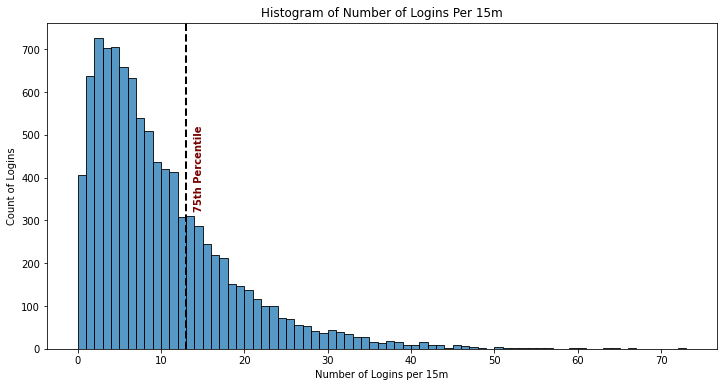

In [73]:
plt.figure(figsize=(12,6))
ax = sns.histplot(login15, label='Login Counts', binwidth=1, legend=False)
ax.set(xlabel='Number of Logins per 15m', ylabel='Count of Logins', title='Histogram of Number of Logins Per 15m');
ax.axvline(13, color='black', linestyle='--', linewidth=2)
ax.text(14,325, '75th Percentile', rotation=90, color='#780000', fontweight='semibold')

0 logins appears many times compared to 73 logins which happened only once. The number of logins typically range from 0-13

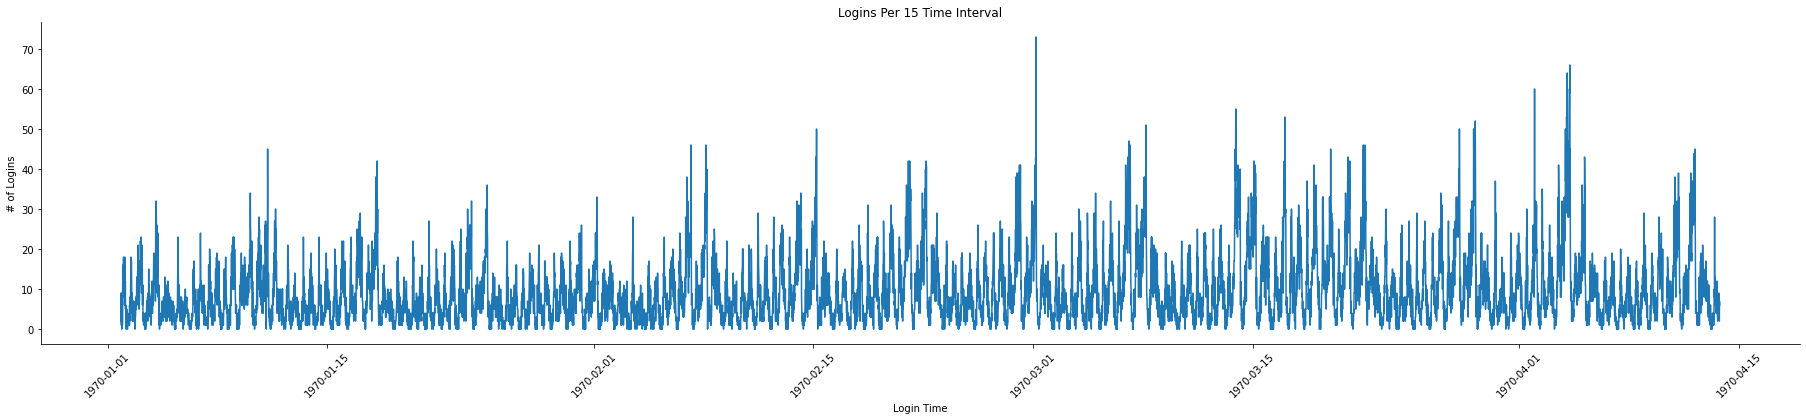

In [34]:
ax = sns.relplot(x='login_time',y='count', data=login15, kind='line', height=5, aspect=5)
ax.set(xlabel= 'Login Time', ylabel='# of Logins', title='Logins Per 15 Time Interval')
ax.set_xticklabels(rotation=45)

There appears to be some kind of a seasonality

In [75]:
login15['month'] = login15.login_time.dt.month
#login15['week_of_month'] = login15.login_time.dt.week
login15['day_of_week'] = login15.login_time.dt.dayofweek
login15['hour'] = login15.login_time.dt.hour

C:\Users\monke\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [81]:
dow_map = {0: 'Monday',
           1: 'Tuesday',
           2: 'Wednesday',
           3: 'Thursday',
           4: 'Friday',
           5: 'Saturday',
           6: 'Sunday'}

login15.day_of_week = login15.day_of_week.map(dow_map)

In [82]:
login15

,login_time,count,month,week_of_month,day_of_week,hour
0,1970-01-01 20:00:00,2,1,1,Thursday,20
1,1970-01-01 20:15:00,6,1,1,Thursday,20
2,1970-01-01 20:30:00,9,1,1,Thursday,20
3,1970-01-01 20:45:00,7,1,1,Thursday,20
4,1970-01-01 21:00:00,1,1,1,Thursday,21
...,...,...,...,...,...,...
9783,1970-04-13 17:45:00,5,4,0,Monday,17
9784,1970-04-13 18:00:00,5,4,0,Monday,18
9785,1970-04-13 18:15:00,2,4,0,Monday,18
9786,1970-04-13 18:30:00,7,4,0,Monday,18


<h2> 2. Experiment & Metrics Design </h2>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.    

<h3 style="text-align:right"> 2.1 Key Measure of Success </h3>
<b>What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</b><br />
The key measure of success I would look at is profit and if there is an increase after reimbursing all toll costs. The Ultimate managers don’t want drivers to serve both cities so the drivers can enjoy a change of scenery. By having drivers serve both cities they expand their network of cars without having to add more drivers. With an expanded network of cars, they can serve more users and increase the user experience via reduced wait times and driver availability. All of these benefits will be reflected in profit. If the initiative improves the service, then Ultimate’s profit should increase. Revenue might increase, but since they have to reimbursement the tolls that cost might eat into it, which is why the importance is on profit. 

<h3 style="text-align:right"> 2.2 Practical Experiment Design </h3>
<b>Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.</b><br />

To test the effectiveness of the initiative on profits I would use an A/B test where the test group is a subset of drivers that do get reimbursed for the tolls and the control group is a subset of drivers that don’t get reimbursed for the tolls. The hypothesis for the experiment is as follows:
<ul>
    <li> Null Hypothesis $H_0$: Reimbursing driver tolls has no impact on Ultimate’s profits.</li>
    <li> Alternate Hypothesis $H_1$: Reimbursing driver tolls has an impact on Ultimate’s profits.</li>
</ul>

The partition of the drivers into control and test groups should be random, however after the split two things should be checked before the experiment begins:
<ol>
<li> There should be about the same number of drivers from both types of driver partners, those typically exclusive to Gotham and those typically exclusive to Metropolis. </li>
<li> The distribution of profits for both groups should also be about the same. If drivers in one of group have higher profit levels beforehand, that would muddy the results and interpretation of the experiment.  
</ol>

Assuming the test is successful and reimbursing tolls increases profits I would want to see the percentage increase in profits. Additionally, profits for Ultimate and profits for their drivers are two different things. They might be getting toll reimbursements but going across the bridge increases the wear and tear on the vehicle as well as the gas consumed. Additionally, if the driver goes across the bridge for a trip and then never gets a trip that sends him back over, he would be responsible for the toll to get back home when he is done working (assuming they only reimburse when the driver is on duty). Something that might be worth further investigation is if they need to reimburse all toll costs or only toll costs at certain times, like how they have “hot-zones” that pay out double the money.
The last thing that should be evaluated is how sustainable the initiative is if things change, some factors that could affect the initiative are the toll costs, the number of driver partners, and the number of riders. 




<h2> 3. Predictive Modeling </h2>